# RNN 실행계획

1. input : 요일, 공휴일 유무를 집어넣는다.
2. 점심(한식), 점심(양식)을 따로 예측한다. 
3. 예측치 , 실측치 차이가 큰 지점을 살펴본다.
    - 메뉴를 통해서 그 차이를 보정할 수 있는지 돌려본다.
    - 메뉴는 주메뉴 그중에서 육류, 튀김, 생선 등등 이런걸 쓰고 예측치-실측치 차이를 regression한다. 
    - (예상결과) : 각 메뉴의 중요도를 살필 수 있ㄷ을거같다. 
    
4. 여유가 생기면 

In [39]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import shutil
from mpl_toolkits.mplot3d import Axes3D
from six.moves import cPickle

import pandas as pd

from sklearn.preprocessing import OneHotEncoder

from RNN import RNNmodel

# intervalDay 7일 버전

In [40]:
from six.moves import cPickle
intervalDay = 3
df_X7 = cPickle.load(open('./trainData{}Morning.pkl'.format(intervalDay), 'rb'))
# df_Y7 = cPickle.load(open('./validDate{}Morning.pkl'.format(intervalDay), 'rb'))
df_pred7 = cPickle.load(open('./predDate{}Morning.pkl'.format(intervalDay), 'rb'))

In [41]:
trainWindow = []
# Train은 우선 바로앞만 예측하는걸로 학습
for orderIndex in df_X7.orderDf.unique():
    tempArray = df_X7[df_X7.orderDf == orderIndex][['date','values','weekday','holiday']].values
    for i in range(len(tempArray)-(intervalDay+4)):
        trainWindow.append(tempArray[i:i+intervalDay+4])
        

# validWindow = []
# for orderIndex in df_Y7.orderDf.unique():
#     tempArray = df_Y7[df_Y7.orderDf == orderIndex][['date','values','weekday','holiday']].values
#     validWindow.append(tempArray)        

    
predWindow = []
for orderIndex in df_pred7.orderDf.unique():
    tempArray = df_pred7[df_pred7.orderDf == orderIndex][['date','values','weekday','holiday']].values
    predWindow.append(tempArray)  
    
trainArray = np.array(trainWindow)
# validArray = np.array(validWindow)
predArray = np.array(predWindow)

In [42]:
realpredArray = []
for i in range(len(predArray)):
    if predArray[i].shape[0] > 9:
        predArray[i] = predArray[i][-9:]
    if predArray[i].shape[0] ==9:
        realpredArray.append(predArray[i])

In [43]:
realpredArray = np.array(realpredArray)

# 예측결과를 어떻게 분석하는가?

- 일단 plot 하는걸 3일 맞추는거 말고도 특정 기간예측결과본 가지고와서 (for문 돌려서 3번째 날짜 쭉 맞추게해서) 경향을 맞추는지 살펴본다.
- total, 서양, 한식 이 세가지 에 대해서 바로위에서 한게 잘 맞는지 살펴본다,

- 위 두가지 하고난 후에야 학습때 사용되지않은 3일을 맞춰본다. 
- input 형태를 어떻게 할지 고민한다. (현재방식 뭔가 찝집함)

- 별개로 메뉴를 활용할 방안을 살펴본다. (메뉴를 보는건 더이상 time 축을 고려하지 않아도 된다고 할 수 있다)

In [9]:
#enc = OneHotEncoder(n_values=7)
#trainArrayOhe = enc.fit_transform(trainArray[:, :, 1]).toarray().reshape(-1, 31, 7)*trainArray[:, :, [0]]
#validArrayOhe = enc.fit_transform(validArray[:, :, 2]).toarray().reshape(-1, 33, 7)

rnn_config = {
    'ID': 'posco_model',
    'rnn_ID' : 'RNNmodel0801_{}day_Morning'.format(intervalDay),
#     'rnn_ID' : 'load',
    'n_batch' : 100,
    'n_save' : 1000,
    'n_prt' : 50,
    'n_iter' : 500000,
    'LR' : 0.0001,
    'n_history' : 100,
    'n_input' : 2+7,
    'n_step' : intervalDay,
    'n_output' : 1, # values_sum은 pred 합으로 예측
    'intervalDay':intervalDay
}


try: 
    os.mkdir('./{}'.format(rnn_config['ID']))
except FileExistsError:
    pass

my_model = RNNmodel(rnn_config)

[FileExistsError] Will you remove directory? [Y/N] Y
Model ID : posco_model
Model saved at : ./posco_model/RNNmodel0801_3day_Morning


In [44]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(n_values=7)
trainArrayOhe = enc.fit_transform(trainArray[:, :, 3]).toarray().reshape(-1, intervalDay+4, 7)
# validArrayOhe = enc.fit_transform(validArray[:, :, 3]).toarray().reshape(-1, intervalDay+3, 7)
realpredArrayohe = enc.fit_transform(realpredArray[:, :, 3]).toarray().reshape(-1, intervalDay+3+3, 7)

In [18]:
def week_ohe(all_array, week_array):
    return np.concatenate((all_array[:, :, [0, 1, 3]], week_array), 2)

In [19]:
train_idx = list(np.arange(0, 700))+list(np.arange(850,1500))+list(np.arange(1600,2800))+list(np.arange(2900,3236))
valid_idx = list(np.arange(750, 850))+list(np.arange(1500,1600))+list(np.arange(2800,2900))

trainX = week_ohe(trainArray, trainArrayOhe)[train_idx, :, 1:]
trainY = week_ohe(trainArray, trainArrayOhe)[train_idx, intervalDay+1:, 1:2]


validX = week_ohe(trainArray, trainArrayOhe)[valid_idx, :, 1:]
validY = week_ohe(trainArray, trainArrayOhe)[valid_idx, intervalDay+1:, 1:2]

In [20]:
my_model.fit(trainX, trainY, validX, validY)

49/500001Your Train loss (50/500000) : 28.629344940185547
Your Valid loss (50/500000) : 25.757352828979492
99/500001Your Train loss (100/500000) : 32.645721435546875
Your Valid loss (100/500000) : 24.711149215698242
149/500001Your Train loss (150/500000) : 38.945255279541016
Your Valid loss (150/500000) : 14.756160736083984
199/500001Your Train loss (200/500000) : 25.086584091186523
Your Valid loss (200/500000) : 23.32526206970215
249/500001Your Train loss (250/500000) : 25.300308227539062
Your Valid loss (250/500000) : 21.123716354370117
299/500001Your Train loss (300/500000) : 23.817214965820312
Your Valid loss (300/500000) : 14.395305633544922
349/500001Your Train loss (350/500000) : 32.708839416503906
Your Valid loss (350/500000) : 25.667011260986328
399/500001Your Train loss (400/500000) : 21.330705642700195
Your Valid loss (400/500000) : 28.82244110107422
449/500001Your Train loss (450/500000) : 31.747385025024414
Your Valid loss (450/500000) : 26.065702438354492
499/500001Your T

3549/500001Your Train loss (3550/500000) : 43.68080520629883
Your Valid loss (3550/500000) : 21.501951217651367
3599/500001Your Train loss (3600/500000) : 25.172405242919922
Your Valid loss (3600/500000) : 18.764755249023438
3649/500001Your Train loss (3650/500000) : 28.584569931030273
Your Valid loss (3650/500000) : 23.1217098236084
3699/500001Your Train loss (3700/500000) : 25.557199478149414
Your Valid loss (3700/500000) : 20.475435256958008
3749/500001Your Train loss (3750/500000) : 17.182641983032227
Your Valid loss (3750/500000) : 26.652009963989258
3799/500001Your Train loss (3800/500000) : 121.69998931884766
Your Valid loss (3800/500000) : 23.05388832092285
3849/500001Your Train loss (3850/500000) : 28.181028366088867
Your Valid loss (3850/500000) : 20.098953247070312
3899/500001Your Train loss (3900/500000) : 25.29303741455078
Your Valid loss (3900/500000) : 29.10091781616211
3949/500001Your Train loss (3950/500000) : 37.879722595214844
Your Valid loss (3950/500000) : 19.36945

KeyboardInterrupt: 

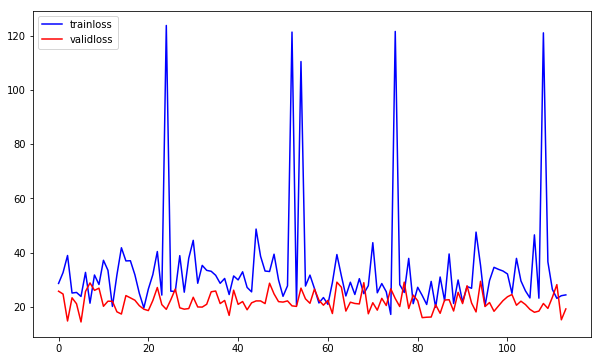

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(my_model.train_history)), my_model.train_history, 'b', label='trainloss')
plt.plot(np.arange(len(my_model.valid_history)), my_model.valid_history, 'r', label='validloss')
plt.legend()
plt.show()

In [22]:
my_model.load('./posco_model/RNNmodel0801_3day_Morning/checkpoint/RNNmodel0801_3day_Morning_7000')

INFO:tensorflow:Restoring parameters from ./posco_model/RNNmodel0801_3day_Morning/checkpoint/RNNmodel0801_3day_Morning_7000
Model loaded from file : ./posco_model/RNNmodel0801_3day_Morning/checkpoint/RNNmodel0801_3day_Morning_7000


In [23]:
def predict_three(_array, my_model, intervalDay):
    enc = OneHotEncoder(n_values=7)
    _arrayohe = enc.fit_transform(_array[:, :, 2]).toarray().reshape(-1, _array.shape[1], 7)
    array = week_ohe(_array, _arrayohe)
    firstInput = array[:, :intervalDay, 1:].copy()

    firstResult = my_model.predict(firstInput)

    secondInput = array[:, 1:intervalDay+1, 1:].copy()
    secondInput[:, -1, 1:2] = firstResult
    secondResult = my_model.predict(secondInput)

    thirdInput = array[:, 2:intervalDay+2, 1:].copy()
    thirdInput[:, -1, 1:2] = secondResult
    thirdResult = my_model.predict(thirdInput)
    return np.concatenate((firstResult[:, np.newaxis, :], 
                           secondResult[:, np.newaxis, :], 
                           thirdResult[:, np.newaxis, :]), 1)

# 전체 날짜에대해서 (학습때쓴거) 비교하기

- RNN결과저장하기
- 이제이걸로 예측할거

## Train  index

In [24]:


predict_result = predict_three(trainArray[train_idx], my_model, intervalDay)

day = trainArray[train_idx, -1, 0]
week = trainArray[train_idx, -1, 2]
true_kor = trainArray[train_idx, -1, 1]
pred_kor = predict_result[:, 2, 0]



pred_train = np.concatenate((day[:, np.newaxis],
                             true_kor[:, np.newaxis],
                             pred_kor[:, np.newaxis],
                            week[:, np.newaxis]),
                            1)

pred_train_df = pd.DataFrame(pred_train)
pred_train_df.columns = ['date', 'true_kor', 
                         'pred_kor', 'week']


In [25]:
pred_train_df

,date,true_kor,pred_kor,week
0,2003-03-08 00:00:00,43.2491,48.9713,5
1,2003-03-09 00:00:00,38.0505,47.525,6
2,2003-03-10 00:00:00,49.0975,45.1891,0
3,2003-03-11 00:00:00,49.2419,48.6634,1
4,2003-03-12 00:00:00,48.0144,50.627,2
5,2003-03-13 00:00:00,56.1733,54.1624,3
6,2003-03-14 00:00:00,50.8303,50.5636,4
7,2003-03-15 00:00:00,44.7653,51.8883,5
8,2003-03-16 00:00:00,39.639,48.8099,6
9,2003-03-17 00:00:00,47.7978,52.7029,0


## valid index

In [26]:


predict_result = predict_three(trainArray[valid_idx], my_model, intervalDay)

day = trainArray[valid_idx, -1, 0]
true_kor = trainArray[valid_idx, -1, 1]
pred_kor = predict_result[:, 2, 0]
week = trainArray[valid_idx, -1, 2]


pred_train = np.concatenate((day[:, np.newaxis],
                             true_kor[:, np.newaxis],
                             pred_kor[:, np.newaxis],
                            week[:, np.newaxis]),
                            1)

pred_valid_df = pd.DataFrame(pred_train)
pred_valid_df.columns = ['date', 'true_kor', 
                         'pred_kor', 'week']



In [38]:
np.sqrt(np.mean(np.square(pred_valid_df['true_kor'] - pred_valid_df['pred_kor'] )))

8.91139097223055

In [27]:
pred_valid_df

,date,true_kor,pred_kor,week
0,2005-05-04 00:00:00,45.343,49.6571,2
1,2005-05-05 00:00:00,33.1408,51.0133,3
2,2005-05-06 00:00:00,38.1227,51.1914,4
3,2005-05-07 00:00:00,34.5848,50.737,5
4,2005-05-08 00:00:00,28.8087,45.6359,6
5,2005-05-09 00:00:00,39.639,40.7153,0
6,2005-05-10 00:00:00,44.7653,42.1272,1
7,2005-05-11 00:00:00,43.3935,43.7597,2
8,2005-05-12 00:00:00,44.2599,47.6845,3
9,2005-05-13 00:00:00,42.4549,50.2104,4


## test index

predict_result_val = predict_three(validArray, my_model, intervalDay)

day_val = validArray[:, -1, 0]
true_kor_val = validArray[:, -1, 1]
week_val = validArray[:, -1, 2]
pred_kor_val = predict_result_val[:, -1, 0]
pred_test = np.concatenate((day_val[:, np.newaxis],
                             true_kor_val[:, np.newaxis],
                             pred_kor_val[:, np.newaxis],
                           week_val[:, np.newaxis]),
                            1)

pred_test_df = pd.DataFrame(pred_test)
pred_test_df.columns = ['date', 'true_kor', 
                         'pred_kor', 'week']


pred_test_df

## predict

In [45]:
result_ar = []
day_ar = []
pred_kor_ar = []
pred_west_ar = []
true_kor_ar = []
true_west_ar = []
week_ar = []
for i in range(0, 3):
    predict_result = predict_three(realpredArray[:, i:intervalDay+3+i, :], my_model, intervalDay)
    day_ar.append(realpredArray[:, [intervalDay+3+i], 0])
    pred_kor_ar.append(predict_result[:, [-1], 0])
    true_kor_ar.append(realpredArray[:, [intervalDay+3+i], 1])
    week_ar.append(realpredArray[:, [intervalDay+3+i], 2])

In [46]:
pred_submit = np.concatenate((np.concatenate(day_ar, 1).reshape(-1, 1),
                             np.concatenate(true_kor_ar, 1).reshape(-1, 1),
                             np.concatenate(pred_kor_ar, 1).reshape(-1, 1),
                             np.concatenate(week_ar, 1).reshape(-1, 1)),
                            1)

In [47]:
pred_submit_df = pd.DataFrame(pred_submit)
pred_submit_df.columns = ['date', 'true_kor', 
                         'pred_kor', 'week']



In [48]:
for i in range(37):
    print (pred_submit_df.set_index('date')[0+3*i:3+3*i])

           true_kor pred_kor week
date                             
2003-06-13        0  49.9256    0
2003-06-14  43.0325   49.215    5
2003-06-15  43.3213  49.2517    6
           true_kor pred_kor week
date                             
2004-02-28        0  47.3115    0
2004-02-29        0  44.3527    0
2004-03-01        0  52.9865    0
           true_kor pred_kor week
date                             
2008-12-28        0  44.0622    0
2008-12-29  39.1336  42.3156    0
2008-12-30  35.8845   44.525    1
           true_kor pred_kor week
date                             
2009-07-15        0  43.5682    0
2009-07-16        0  45.5391    0
2009-07-17        0  48.9337    0
           true_kor pred_kor week
date                             
2010-07-13        0  52.1374    1
2010-07-14        0  47.9415    2
2010-07-15        0    47.59    3
           true_kor pred_kor week
date                             
2011-03-09        0  30.6331    2
2011-03-10        0  33.9778    3
2011-03-11    

In [49]:
cPickle.dump([pred_train_df, pred_valid_df, pred_submit_df], open('RNNReusltMorning.pkl', 'wb'))

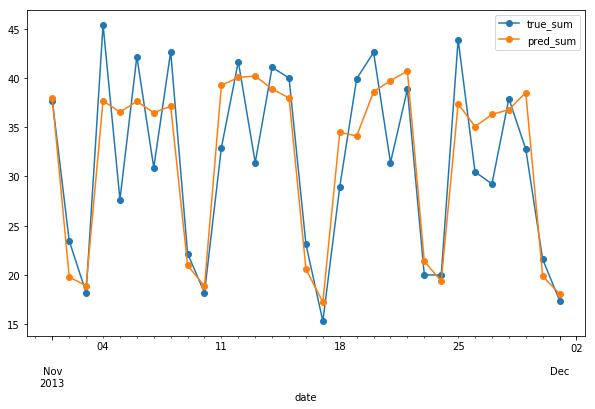

In [27]:
start_date = '2013-11-01'
end_date = '2013-12-30'

_EachDay = pred_train_df[['date','true_sum','pred_sum']]\
            .set_index('date')\
            [start_date:end_date]
_EachDay.plot(figsize=(10,6), style='-o')
plt.show()

In [28]:
predict_result_val = predict_three(validArray, my_model, intervalDay)

In [29]:
day_val = validArray[:, -1, 0]
true_kor_val = validArray[:, -1, 1]
true_west_val = validArray[:, -1, 2]
pred_kor_val = predict_result_val[:, -1, 0]
pred_west_val = predict_result_val[:, -1, 1]

In [30]:
pred_val = np.concatenate((day_val.reshape(-1, 1),
                             true_kor_val.reshape(-1, 1), true_west_val.reshape(-1, 1),
                             pred_kor_val.reshape(-1, 1), pred_west_val.reshape(-1, 1)),
                            1)

pred_val = np.concatenate((day_val[:, np.newaxis],
                             true_kor_val[:, np.newaxis], true_west_val[:, np.newaxis],
                             pred_kor_val[:, np.newaxis], pred_west_val[:, np.newaxis]),
                            1)

In [31]:
pred_val_df = pd.DataFrame(pred_val)
pred_val_df.columns = ['date', 'true_kor', 'true_west', 
                         'pred_kor', 'pred_west']

In [32]:
pred_val_df['true_sum'] = pred_val_df['true_kor']+pred_val_df['true_west']
pred_val_df['pred_sum'] = pred_val_df['pred_kor']+pred_val_df['pred_west']

In [33]:
print (np.sqrt(np.mean(np.square(pred_val_df['true_sum'] - pred_val_df['pred_sum']))))
print (np.sqrt(np.mean(np.square(pred_val_df['true_kor'] - pred_val_df['pred_kor']))))
print (np.sqrt(np.mean(np.square(pred_val_df['true_west'] - pred_val_df['pred_west']))))


6.60227397442662
6.680945546632854
4.227205910696232


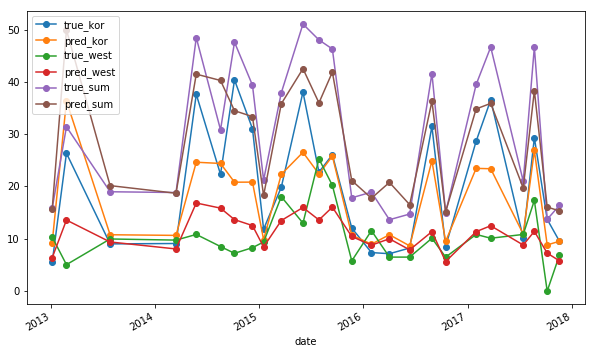

In [34]:
start_date = '2012-12-01'
end_date = '2017-12-30'

_EachDay = pred_val_df[['date','true_kor','pred_kor','true_west','pred_west','true_sum','pred_sum']]\
            .set_index('date')\
            [start_date:end_date]
_EachDay.plot(figsize=(10,6), style='-o')
plt.show()

In [35]:
_EachDay

,true_kor,pred_kor,true_west,pred_west,true_sum,pred_sum
date,,,,,,
2013-01-06,5.48736,9.25453,10.3249,6.38925,15.8123,15.6438
2013-02-25,26.3538,36.341,5.05415,13.5801,31.4079,49.9211
2013-07-28,9.02527,10.7725,9.9639,9.39091,18.9892,20.1634
2014-03-16,9.09747,10.6489,9.74729,8.05631,18.8448,18.7052
2014-05-26,37.6173,24.6326,10.8303,16.8385,48.4477,41.4711
2014-08-19,22.3105,24.4008,8.51986,15.8597,30.8303,40.2605
2014-10-07,40.361,20.818,7.22022,13.6594,47.5812,34.4774
2014-12-09,31.0469,20.8319,8.30325,12.5255,39.3502,33.3574
2015-01-17,11.8412,9.83778,9.38628,8.44253,21.2274,18.2803


In [36]:
print (np.sqrt(np.mean(np.square(thirdResult[:,0] - validPeopleTrue[:,0]))))
print (np.sqrt(np.mean(np.square(thirdResult[:,1] - validPeopleTrue[:,1]))))

NameError: name 'thirdResult' is not defined

In [37]:
pred_dates = validArray[:, intervalDay:, 0].reshape(-1, 1)
trueResult0 = validArray[:, intervalDay:, 1].reshape(-1, 1)
trueResult1 = validArray[:, intervalDay:, 2].reshape(-1, 1)

predResult1 = np.concatenate([firstResult[:, [1]], secondResult[:, [1]], thirdResult[:, [1]]], 1).reshape(-1, 1)
predResult0 = np.concatenate([firstResult[:, [0]], secondResult[:, [0]], thirdResult[:, [0]]], 1).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(trueResult0+trueResult1, 'r', label='True0')
plt.plot(predResult0+predResult1, 'b', label='Pred0')
plt.legend()
plt.show()

NameError: name 'firstResult' is not defined

In [38]:
pred_dates = validArray[:, intervalDay:, 0].reshape(-1, 1)
trueResult0 = validArray[:, intervalDay:, 1].reshape(-1, 1)
trueResult1 = validArray[:, intervalDay:, 2].reshape(-1, 1)

predResult1 = np.concatenate([firstResult[:, [1]], secondResult[:, [1]], thirdResult[:, [1]]], 1).reshape(-1, 1)
predResult0 = np.concatenate([firstResult[:, [0]], secondResult[:, [0]], thirdResult[:, [0]]], 1).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title('Three Day(one, two, three)')
plt.plot(trueResult0, 'r', label='True0')
plt.plot(predResult0, 'b', label='Pred0')
plt.legend()
#plt.xticks(np.arange(0, 48*3), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
#plt.savefig('threeday.png')
#plt.show()

#plt.figure(figsize=(10, 6))
#plt.title('Three Day(one, two, three)')
plt.plot(trueResult1, 'm', label='True1')
plt.plot(predResult1, 'g', label='Pred1')
plt.legend()
#plt.xticks(np.arange(0, 48*3), pred_dates.astype('datetime64[M]').reshape(-1), rotation='vertical')
#plt.savefig('threeday.png')
plt.show()

NameError: name 'firstResult' is not defined